In [119]:
import numpy as np
import scipy as sc
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import json

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 20
plt.rcParams['ytick.labelsize'] = 20
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['axes.labelsize'] = 24
plt.rcParams['legend.fontsize'] = 22

from sklearn.linear_model import LinearRegression

from qpfs import get_corr_matrix, shift_spectrum, QPFS, MultivariateQPFS

lr = LinearRegression()

In [2]:
def RMSE(Y, P):
    return np.sqrt(np.mean((Y - P) ** 2))


def metric_vif(active_idxs):
    with open('res/ecog_vifx.json', 'r') as f:
        vifx = np.array(json.loads(f.read()))[active_idxs]
    return np.max(vifx)


def metric_stability(X):
    ev = np.linalg.eigh(X.T.dot(X))[0]
    return np.log(ev[0] / ev[-1])


def metric_rmse(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    return np.mean(np.sqrt(np.mean((Y - Y_pred) ** 2, axis=0)))


def metric_bic(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    m, p = X.shape
    return np.mean(np.log(np.mean((Y - Y_pred) ** 2, axis=0))) + p * np.log(m) / m


def metric_aic(X, Y, est=None):
    if est is None:
        est = LinearRegression()
        est.fit(X, Y)
    Y_pred = est.predict(X)
    m, p = X.shape
    return np.mean(np.log(np.mean((Y - Y_pred) ** 2, axis=0))) + 2 * p / m


def metric_corr(Q, b, active_idxs):
    b = b[active_idxs]
    Q = Q[active_idxs][:, active_idxs]
    return b.T.dot(np.linalg.pinv(Q)).dot(b)

In [3]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar


def get_bootstrap(X, Y):
    n = X.shape[0]
    idxs = np.random.choice(np.arange(n), size=n)
    return X[idxs], Y[idxs]

In [4]:
def get_metrics(n_active_array, alpha3_array, score_history, Xtrain, Ytrain, Xtest, Ytest):
    results = {}
    results['score'] = []
    results['train_rmse'] =[]
    results['test_rmse'] = []
    results['stability'] = []
    results['vif'] = []
    results['aic'] = []
    results['bic'] = []
    results['corr'] = []
    results['alphas'] = alpha3_array.tolist()
    results['n_active_array'] = n_active_array.tolist()
    
    Q = get_corr_matrix(Xtrain)
    B = get_corr_matrix(Xtrain, Ytrain)
    
    for score in tqdm_notebook(score_history):
        idxs_sort = score.argsort()[::-1]

        train_rmse = []
        test_rmse = []
        stability = []
        vif = []
        bic = []
        aic = []
        corr = []

        for k in n_active_array:
            active_idxs = idxs_sort[:k]
            lr.fit(Xtrain[:, active_idxs], Ytrain)
            train_rmse.append(metric_rmse(Xtrain[:, active_idxs], Ytrain, lr))
            test_rmse.append(metric_rmse(Xtest[:, active_idxs], Ytest, lr))
            stability.append(metric_stability(Xtrain[:, active_idxs]))
            vif.append(metric_vif(active_idxs))
            bic.append(metric_bic(Xtrain[:, active_idxs], Ytrain, lr))
            aic.append(metric_aic(Xtrain[:, active_idxs], Ytrain, lr))
            corr.append(np.mean(np.diag(metric_corr(Q, B, active_idxs))))

        results['score'].append(score[idxs_sort].tolist())
        results['train_rmse'].append(train_rmse)
        results['test_rmse'].append(test_rmse)
        results['stability'].append(stability)
        results['vif'].append(vif)
        results['bic'].append(bic)
        results['aic'].append(aic)
        results['corr'].append(corr)
        
    return results

In [108]:
def plot_metrics(results):
    k = len(results['n_active_array']) // 2
    n_feats = []
    fig, ax = plt.subplots(2, 2, figsize=(15, 10), sharex=True)
    for i, score in enumerate(results['score'][0]):
        n_feats.append(np.sum(score > 1e-6))
        p = ax[0, 0].semilogy(score[:n_features // 2], label=results['alphas'][i], linewidth=2.0)
        ax[0, 0].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[0, 0].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
        if i == 4:
            break
    ax[0, 0].set_ylabel('Importance')

#     for i, (r, s) in enumerate(zip(*results['train_rmse'])):
#         p = ax[1, 0].plot(results['n_active_array'], r, label=results['alphas'][i], linewidth=2.0)
#         ax[1, 0].axvline(n_features[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
#         ax[1, 0].axvline(n_features[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
#     ax[1, 0].set_ylabel('RMSE train')

    for i, (r, s) in enumerate(zip(*results['test_rmse'])):
        p = ax[1, 0].plot(results['n_active_array'][:k], r[:k], label=results['alphas'][i], linewidth=2.0)
        ax[1, 0].fill_between(results['n_active_array'][:k], r[:k] - s[:k], r[:k] + s[:k], alpha=0.3)
        ax[1, 0].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[1, 0].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
        if i == 4:
            break
    ax[1, 0].set_ylabel('RMSE test')
    ax[1, 0].set_xlabel('Features')

#     for i, (r, s) in enumerate(zip(*results['stability'])):
#         p = ax[0, 1].plot(results['n_active_array'], r, label=results['alphas'][i], linewidth=2.0)
#         ax[0, 1].axvline(n_features[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
#         ax[0, 1].axvline(n_features[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
#     ax[0, 1].set_ylabel('Stability')
    
    for i, (r, s) in enumerate(zip(*results['corr'])):
        p = ax[0, 1].plot(results['n_active_array'][:k], r[:k], label=results['alphas'][i], linewidth=2.0)
        ax[0, 1].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[0, 1].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
        if i == 4:
            break
    ax[0, 1].set_ylabel('Multicorrelation')
    ax[0, 1].legend()
    
    for i, (r, s) in enumerate(zip(*results['bic'])):
        p = ax[1, 1].plot(results['n_active_array'][:k], r[:k], label=results['alphas'][i], linewidth=2.0)
        ax[1, 1].axvline(n_feats[i], ymin=0., ymax=.05, c=p[0].get_color(), linewidth=3.0)
        ax[1, 1].axvline(n_feats[i], ymin=.95, ymax=1., c=p[0].get_color(), linewidth=3.0)
        if i == 4:
            break
    ax[1, 1].set_ylabel('BIC')
    ax[1, 1].set_xlabel('Features')

    fig.tight_layout()
    plt.savefig('figs/ecog_3_{}_metrics.pdf'.format(step), format='pdf')
    plt.show()

In [52]:
Xtrain = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Ytrain = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

Xtest = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Ytest = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

n_samples, n_features = Xtrain.shape

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


In [7]:
qpfs_relagg = QPFS()
qpfs_symimp = MultivariateQPFS(mode='SymImp')
qpfs_minmax = MultivariateQPFS(mode='MinMax')
qpfs_maxmin = MultivariateQPFS(mode='MaxMin')
qpfs_maxrel = MultivariateQPFS(mode='MaxRel')
qpfs_minmax2 = MultivariateQPFS(mode='MinMax2')

In [74]:
steps = [21]
n_restarts = 5

for step in steps:
    Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
    Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0] - step + 1], Xtest[:Xtest.shape[0] - step + 1]
    print('step', step)
    print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

    qpfs_relagg.fit(Xtrain_ar, Ytrain_ar)
    qpfs_symimp.fit(Xtrain_ar, Ytrain_ar)
    qpfs_minmax.fit(Xtrain_ar, Ytrain_ar)
    qpfs_maxmin.fit(Xtrain_ar, Ytrain_ar)
    qpfs_maxrel.fit(Xtrain_ar, Ytrain_ar)
    qpfs_minmax2.fit(Xtrain_ar, Ytrain_ar)

    score_history = [qpfs_relagg.score, 
                     qpfs_symimp.zx, 
                     qpfs_minmax.zx, 
                     qpfs_maxmin.zx, 
                     qpfs_maxrel.zx,
                     qpfs_minmax2.zx
                    ]
    
    n_active_array = np.arange(1, n_features, 10)
    algs = np.array(['RelAgg', 'SymImp', 'MinMax', 'MaxMin', 'MaxRel', 'MinMax2'])
    
    for i in range(n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)
        results = get_metrics(n_active_array, algs, score_history, 
                              X, Y, Xtest_ar, Ytest_ar)

        with open('res/qpfs_vs_mqpfs_ecog_3_{}_bootstrap_{}.json'.format(step, i), 'w') as f:
            f.write(json.dumps(results))
    print('-' * 40)

step 21
(12781, 63) (12781, 864) (6067, 63) (6067, 864)


A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget


----------------------------------------


In [109]:
step = 18
n_restarts = 5

agg_results = {'score': [],
               'train_rmse': [], 
               'test_rmse': [], 
               'stability': [],
               'vif': [],
               'aic': [],
               'bic': [],
               'corr': []
              }

for i in range(n_restarts):
    with open('res/qpfs_vs_mqpfs_ecog_3_{}_bootstrap_{}.json'.format(step, i), 'r') as f:
        results = json.loads(f.read())
    for key in agg_results:
        agg_results[key].append(results[key])

for key in agg_results:
    ar = np.array(agg_results[key])
    agg_results[key] = (ar.mean(axis=0), ar.std(axis=0))

agg_results['alphas'] = results['alphas']
agg_results['n_active_array'] = results['n_active_array']

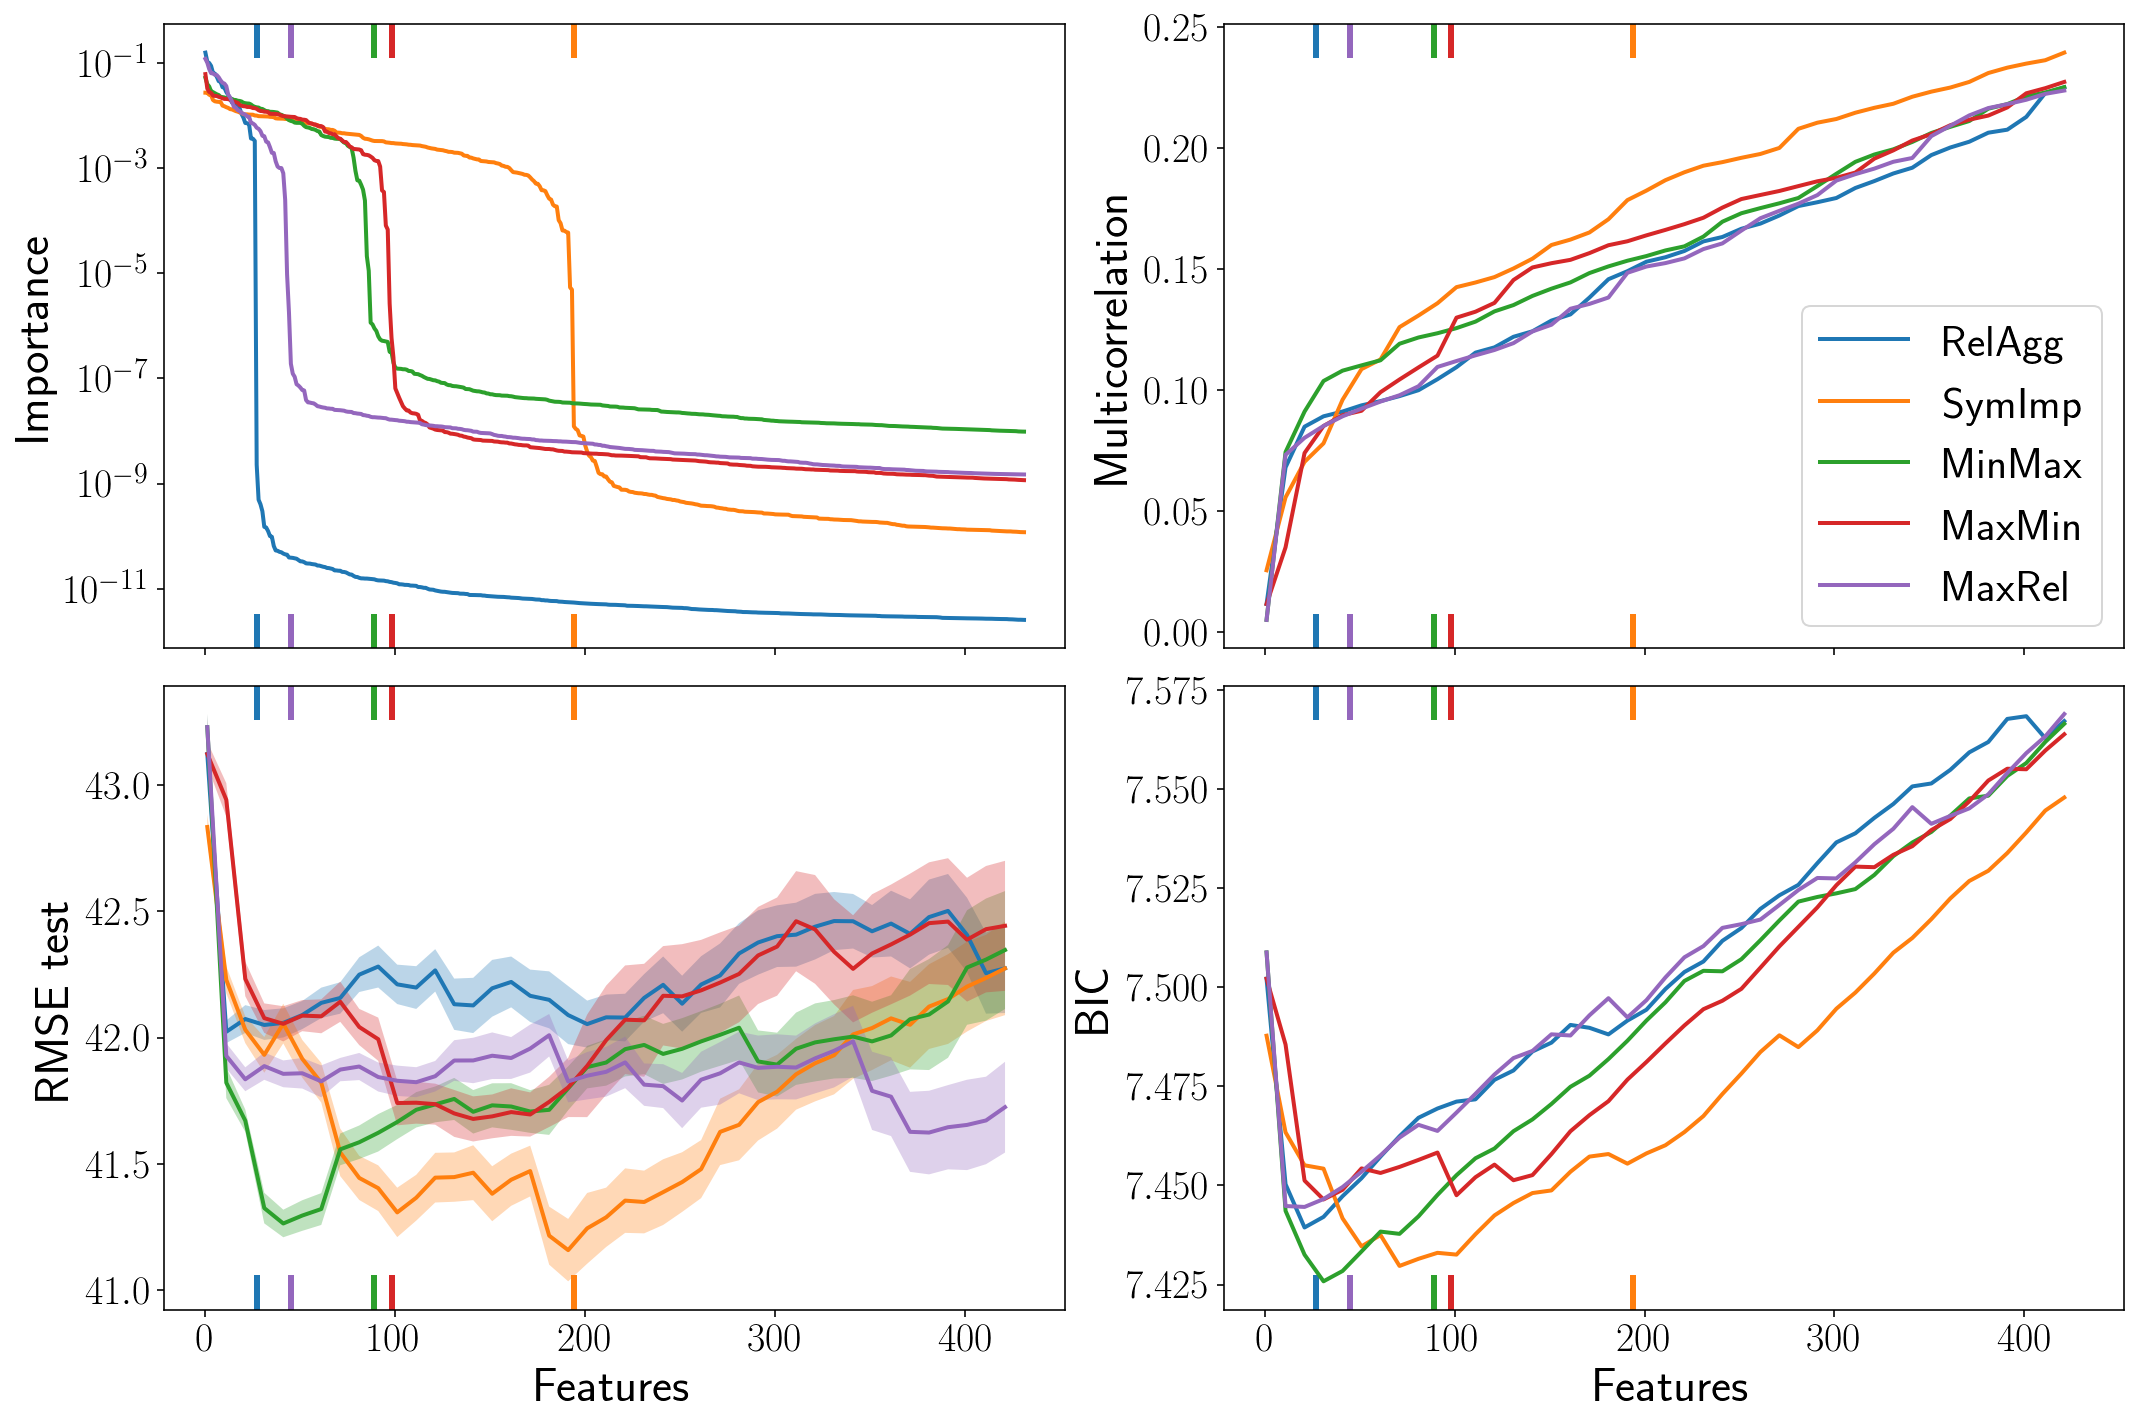

In [120]:
plot_metrics(agg_results)

# TABLE

In [98]:
steps = [18, 21]
n_restarts = 5

for step in steps:
    Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
    Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0] - step + 1], Xtest[:Xtest.shape[0] - step + 1]

    print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)
    
    for i in tqdm_notebook(range(n_restarts), total=n_restarts):
        X, Y = get_bootstrap(Xtrain_ar, Ytrain_ar)

        qpfs_relagg.fit(X, Y)
        qpfs_symimp.fit(X, Y)
        qpfs_minmax.fit(X, Y)
        qpfs_maxmin.fit(X, Y)
        qpfs_maxrel.fit(X, Y)
        qpfs_minmax2.fit(X, Y)
        
        score_history = [qpfs_relagg.score.tolist(), 
                         qpfs_symimp.zx.tolist(), 
                         qpfs_minmax.zx.tolist(), 
                         qpfs_maxmin.zx.tolist(), 
                         qpfs_maxrel.zx.tolist(),
                         qpfs_minmax2.zx.tolist()
                        ]

        with open('res/mqpfs_scores_ecog_3_{}_bootstrap_{}.json'.format(step, i), 'w') as f:
            f.write(json.dumps(score_history))

(12784, 54) (12784, 864) (6070, 54) (6070, 864)


A Jupyter Widget


(12781, 63) (12781, 864) (6067, 63) (6067, 864)


A Jupyter Widget

In [104]:
from itertools import combinations

step = 21
n_restarts = 5

algs = ['RelAgg', 'SymImp', 'MinMax', 'MaxMin', 'MaxRel', 'MaxMin2']

score_history = []
for i in range(n_restarts):
    with open('res/mqpfs_scores_ecog_3_{}_bootstrap_{}.json'.format(step, i), 'r') as f:
        score_history.append(json.loads(f.read()))
        
Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0] - step + 1], Xtest[:Xtest.shape[0] - step + 1]

for i in range(6):
    print(algs[i])
    sh = [np.array(s[i])[:n_features] for s in score_history]
    corrs = []
    l2s = []
    l1s = []
    comps = []
    hams = []
    rmse = []
    for s1, s2 in combinations(sh, 2):
        corrs.append(sc.stats.spearmanr(s1, s2)[0])
        l2s.append(np.sqrt(np.sum((s1 - s2) ** 2)))
        l1s.append(np.sum(np.abs(s1 - s2)))
        hams.append(sc.spatial.distance.hamming(s1 > 1e-6, s2 > 1e-6))
        
    for s1 in sh:
        comps.append(np.sum(s1 > 1e-6))
        active_idxs = s1.argsort()[::-1][:np.sum(s1 > 1e-6)]
        lr.fit(Xtrain_ar[:, active_idxs], Ytrain_ar)
        rmse.append(metric_rmse(Xtest_ar[:, active_idxs], Ytest_ar, lr))

    mean_corr = np.mean(corrs)
    std_corr = np.std(corrs)
    
    mean_l2 = np.mean(l2s)
    std_l2 = np.std(l2s)
    
    mean_l1 = np.mean(l1s)
    std_l1 = np.std(l1s)
    
    mean_comp = np.mean(comps)
    std_comp = np.std(comps)
    
    mean_ham = np.mean(hams)
    std_ham = np.std(hams)
    
    mean_rmse = np.mean(rmse)
    std_rmse = np.std(rmse)
    
    print(f'corr {mean_corr:.3f} $\pm$ {std_corr:.3f}')
    print(f'l2 {mean_l2:.3f} $\pm$ {std_l2:.3f}')
    print(f'l1 {mean_l1:.3f} $\pm$ {std_l1:.3f}')
    print(f'comp {mean_comp:.1f} $\pm$ {std_comp:.1f}')
    print(f'ham {mean_ham:.3f} $\pm$ {std_ham:.3f}')
    print(f'rmse {mean_rmse:.3f} $\pm$ {std_rmse:.3f}')
    print('-' * 80)

RelAgg
corr 0.925 $\pm$ 0.016
l2 0.136 $\pm$ 0.018
l1 0.626 $\pm$ 0.059
comp 27.0 $\pm$ 2.4
ham 0.022 $\pm$ 0.003
rmse 41.939 $\pm$ 0.109
--------------------------------------------------------------------------------
SymImp
corr 0.923 $\pm$ 0.018
l2 0.028 $\pm$ 0.003
l1 0.327 $\pm$ 0.033
comp 198.6 $\pm$ 3.8
ham 0.076 $\pm$ 0.010
rmse 41.082 $\pm$ 0.058
--------------------------------------------------------------------------------
MinMax
corr 0.931 $\pm$ 0.007
l2 0.096 $\pm$ 0.010
l1 0.755 $\pm$ 0.071
comp 92.4 $\pm$ 8.2
ham 0.064 $\pm$ 0.007
rmse 41.381 $\pm$ 0.164
--------------------------------------------------------------------------------
MaxMin
corr 0.945 $\pm$ 0.006
l2 0.063 $\pm$ 0.004
l1 0.524 $\pm$ 0.044
comp 97.0 $\pm$ 4.4
ham 0.046 $\pm$ 0.007
rmse 41.689 $\pm$ 0.113
--------------------------------------------------------------------------------
MaxRel
corr 0.890 $\pm$ 0.031
l2 0.181 $\pm$ 0.012
l1 1.016 $\pm$ 0.061
comp 37.6 $\pm$ 1.6
ham 0.046 $\pm$ 0.006
rmse 41.7